# Fine Tuning Transformer for MultiClass Text Classification

### Introduction

In this tutorial we will be fine tuning a transformer model for the **Multiclass text classification** problem. 
This is one of the most common business problems where a given piece of text/sentence/document needs to be classified into one of the categories out of the given list.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data: 
	 - We are using the News aggregator dataset available at by [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)
	 - We are referring only to the first csv file from the data dump: `newsCorpora.csv`
	 - There are `422937` rows of data.  Where each row has the following data-point: 
		 - ID Numeric ID  
		 - TITLE News title  
		 - URL Url  
		 - PUBLISHER Publisher name  
		 - CATEGORY News category (b = business, t = science and technology, e = entertainment, m = health)  
		 - STORY Alphanumeric ID of the cluster that includes news about the same story  
		 - HOSTNAME Url hostname  
		 - TIMESTAMP Approximate time the news was published, as the number of milliseconds since the epoch 00:00:00 GMT, January 1, 1970


 - Language Model Used:
	 - DistilBERT this is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert. 
	 - [Blog-Post](https://medium.com/huggingface/distilbert-8cf3380435b5)
	 - [Research Paper](https://arxiv.org/abs/1910.01108)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/distilbert.html)


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup 


 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT to be able to classify a news headline into the following categories:
		 - Business
		 - Technology
		 - Health
		 - Entertainment 


<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* DistilBERT Model and Tokenizer

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU. 

In [37]:
# Importing the libraries needed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer,BertModel,BertTokenizer

In [2]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'

df = pd.read_csv('./Final Data/binary-train_no_double_quotes.txt',sep='\t')

df = df[['Sentence','Argument']]
df.shape

(5327, 2)

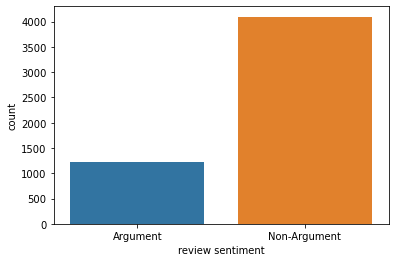

In [4]:
ax = sns.countplot(df['Argument'])
plt.xlabel('review sentiment')
class_names = ['Argument', 'Non-Argument']
ax.set_xticklabels(class_names);

<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing. 
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *Triage* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training. 
- We are using the DistilBERT tokenizer to tokenize the data in the `TITLE` column of the dataframe. 
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)
- `target` is the encoded category on the news headline. 
- The *Triage* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [5]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 70
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2
EPOCHS = 8
LEARNING_RATE = 1e-05
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# tokens = tokenizer.tokenize(sample_txt)

In [6]:
token_lens = []

for txt in df['Sentence']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


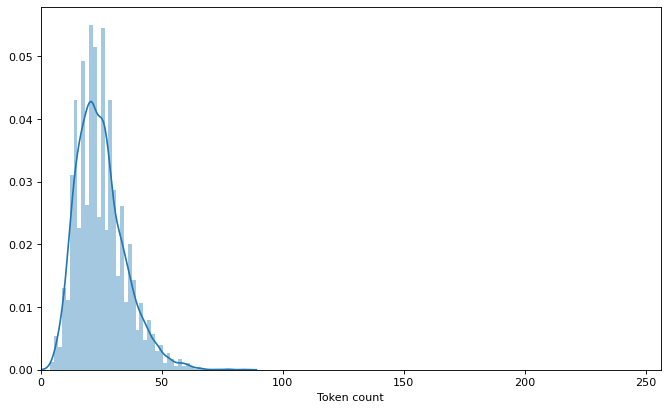

In [7]:

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [8]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.Sentence[index])
#         title = " ".join(title.split())
        encoding = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            #             truncation=True
        )
        ids = encoding['input_ids']
        mask = encoding['attention_mask']

#         return {
#             'ids': torch.tensor(ids, dtype=torch.long),
#             'mask': torch.tensor(mask, dtype=torch.long),
#             'targets': torch.tensor(self.data.Argument[index], dtype=torch.long)
#         }
        return {
            'text': title,
            'ids': encoding['input_ids'].flatten(),
            'mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.data.Argument[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [9]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)
print(training_set.data)

FULL Dataset: (5327, 2)
TRAIN Dataset: (4262, 2)
TEST Dataset: (1065, 2)
                                               Sentence  Argument
0      One benefit is that doing outdoor activities ...         1
1      Entertaining movies are created to amuse peop...         1
2      Universities must admit both in equal numbers...         1
3      In my opinion , I think buying habit is peopl...         1
4      For instance , the Brunei government had rece...         1
...                                                 ...       ...
4257   Thus , it is an oppertunity to learn how to d...         1
4258   Buses and trains have been phased in the stre...         1
4259   The amount of money is always the most import...         1
4260   Firstly , by paying taxes for public school ,...         1
4261   By giving students the freedom to choose abou...         1

[4262 rows x 2 columns]


In [10]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [11]:
data = next(iter(training_loader))
data.keys()

/home/tamvakidis/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2137: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['text', 'ids', 'mask', 'targets'])

In [12]:
print(data['ids'].shape)
print(data['mask'].shape)
print(data['targets'].shape)

torch.Size([2, 70])
torch.Size([2, 70])
torch.Size([2])


<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `DistillBERTClass`. 
 - This network will have the DistilBERT Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs. 
 - The data will be fed to the DistilBERT Language model as defined in the dataset. 
 - Final layer outputs is what will be compared to the `encoded category` to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output. 
 - `Optimizer` is used to update the weights of the neural network to improve its performance.
 
#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about DistiBERT. 

In [13]:
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
# bert_model = BertModel.from_pretrained('bert-base-cased')
output = bert_model(
   input_ids= data['ids'], 
   attention_mask= data['mask']
 )
last_hidden_state = output['last_hidden_state']
pooled_output = output['pooler_output']

In [14]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [15]:
data['ids']

tensor([[  101, 10167, 10684, 21296,   117, 12676, 10479, 30587, 10106, 19118,
         11424, 10301, 24866, 10978, 10455, 18173, 10111, 21852, 10978, 10455,
         11070, 46144,   119,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101, 11399, 14351,   117, 10106,   169, 17531, 22814, 11365,   117,
         11371,   169, 15293, 10393,   169, 11764, 10246, 10111, 18957, 14446,
         23068, 10114, 10105, 18048,   117,   169, 13194, 12971, 14982, 10347,
         12254, 10146, 17034, 63378, 10111, 10173, 40756, 14079, 10114, 42439,
           169, 11206,   118, 10347, 79313, 10336, 18048,   119,   102,     0,
             0,     0,     0,     0,     0,     0, 

In [16]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
#         self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 1)
        self.classifier = torch.nn.Sigmoid()
#       maybe add one sigmoid for the binary classification    
            
#     def forward(self, input_ids, attention_mask):
#         output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_state = output_1[0]
#         pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.ReLU()(pooler)
#         pooler = self.dropout(pooler)
#         output = self.classifier(pooler)
#         return output

    def forward(self, input_ids, attention_mask):
            model_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = model_output['pooler_output']
#             output = self.pre_classifier(pooled_output)
            output = self.dropout(pooled_output)
            output = self.linear(output)
            output = self.classifier(output)
            return output
            
            

In [17]:
model = BERTClass()
model.to(device)

BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [18]:
### Display the shapes and the output of the model for two examples

In [19]:
ids = data['ids'].to(device)
mask = data['mask'].to(device)
# print the batch size and the number of tokes we define
print(ids.shape)
print(mask.shape)

torch.Size([2, 70])
torch.Size([2, 70])


In [20]:
model(ids,mask)

tensor([[0.5423],
        [0.5083]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [21]:
# Creating the loss function and optimizer
# loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.BCELoss() # is The sigmoid
# loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process. 

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network. 

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.0002485 i.e. the output is extremely close to the actual output.

In [30]:
# ids = data['ids'].to(device)
# mask = data['mask'].to(device)
data['targets']

tensor([1])

In [23]:
# Function to calcuate the accuracy of the model
def binary_acc(y_pred, y_test):
#     y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred_tag = torch.round(y_pred)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


# def calcuate_accu(pred, targets):
# #     n_correct = (big_idx==targets).sum().item()
#     n_correct = (pred == targets).sum().float()
#     acc = n_correct/targets.shape[0]
#     acc = torch.round(acc * 100)
#     return acc

In [24]:
def train(epoch):
    print("Epoch Number",epoch)
    epoch_loss = 0
    epoch_accu = 0
    correct_predictions = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for i,data in enumerate(training_loader, 0):

        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        
        targets = data['targets'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         print(type(outputs))
        loss = loss_function(outputs, targets.unsqueeze(1).float())
        acc = binary_acc(outputs,targets.unsqueeze(1))
        correct_predictions += torch.sum(outputs == targets)

        epoch_accu += acc.item()
        epoch_loss += loss.item()

#         nb_tr_steps += 1
#         nb_tr_examples+=targets.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()
#     print("Correct",correct_predictions)
    print(f'Epoch {epoch}: | Loss: {epoch_loss/len(training_loader):.5f} | Acc: {epoch_accu/len(training_loader):.3f}')

    return 

In [25]:
# def eval_model(data_loader, loss_fn, device, n_examples)
# def eval_model():
#   model.eval()
#   losses = []
#   correct_predictions = 0
#   with torch.no_grad():
#     for i,data in enumerate(testing_loader, 0):
        
#       input_ids = data["ids"].to(device)
#       attention_mask = data["mask"].to(device)
#       targets = data["targets"].to(device)
#       outputs = model(
#         input_ids=input_ids,
#         attention_mask=attention_mask
#       )
#       loss = loss_function(outputs, targets)
#       correct_predictions += torch.sum(preds == targets)
#       losses.append(loss.item())
#   return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
import os

In [27]:
# save_path = './Classifier_Training'
save_path = '/home/tamvakidis/Desktop/Tamvakidis_TH/SavedModel'
for epoch in range(EPOCHS):
    train(epoch)
# torch.save(model.state_dict(), save_path) 
torch.save(model.state_dict(), os.path.join(save_path, os.path.join(save_path, "8epochs.bin")))

Epoch Number 0
Epoch 0: | Loss: 0.38128 | Acc: 84.984
Epoch Number 1
Epoch 1: | Loss: 0.28133 | Acc: 89.371
Epoch Number 2
Epoch 2: | Loss: 0.19401 | Acc: 92.938
Epoch Number 3
Epoch 3: | Loss: 0.11174 | Acc: 96.246
Epoch Number 4
Epoch 4: | Loss: 0.08176 | Acc: 97.302
Epoch Number 5
Epoch 5: | Loss: 0.05650 | Acc: 98.193
Epoch Number 6
Epoch 6: | Loss: 0.04542 | Acc: 98.733
Epoch Number 7
Epoch 7: | Loss: 0.04850 | Acc: 98.498


<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the 20% of `newscorpora.csv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As you can see the model is predicting the correct category of a given headline to a 99.9% accuracy.

In [28]:

def valid(model, testing_loader):
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.eval()
    correct_predictions = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            
            
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
        
            targets = data['targets'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#             ids = data['ids'].to(device)
#             mask = data['mask'].to(device)
#             targets = data['targets'].to(device)
#             outputs = model(ids, mask).squeeze()
#             outputs = model(ids, mask)
#             targets = targets.type_as(outputs)
#             print(targets, ids, mask)
            
            loss = loss_function(outputs, targets)
            
            tr_loss += loss.item()     
#             tr_loss += loss.item()
#             print(outputs.data)

            correct_predictions += torch.sum(preds == targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

# acc = valid(model, testing_loader)
y_pred_list = []
y_targets = []
real_values = []
model.eval()
with torch.no_grad():
#     for X_batch in test_loader:
      for _, data in enumerate(testing_loader, 0):
#         X_batch = X_batch.to(device)
        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        targets = data['targets'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         y_test_pred = model(X_batch)
#         y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(outputs)
#         y_pred_list.append(y_pred_tag.cpu().numpy())

        
        real_values.extend(targets)
        y_pred_list.extend(y_pred_tag)
#         prediction_probs.extend(probs)
#         real_values.extend(targets)
real_values = torch.stack(real_values).cpu()  
predictions = torch.stack(y_pred_list).cpu()
# prediction_probs = torch.stack(prediction_probs).cpu()
      
        
        
# y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(sk.metrics.classification_report(real_values, predictions))
# print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model. 

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

Please remember that a trained neural network is only useful when used in actual inference after its training. 

In the lifecycle of an ML projects this is only half the job done. We will leave the inference of these models for some other day. 

In [ ]:
# Saving the files for re-use

output_model_file = './models/pytorch_mult_bertLang_bert.bin'
output_vocab_file = './models/vocab_multLang_bert_.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')